In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import re, sys, os

from transformers import BlipForConditionalGeneration, BlipProcessor
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionPipeline, StableDiffusionPix2PixZeroPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_pix2pix_zero import prepare_unet
from diffusers.utils import BaseOutput

from torchvision.transforms.functional import pil_to_tensor

import requests
import PIL
from PIL import Image
import numpy as np

from typing import Union, List, Tuple, Dict, Callable, Optional, Any

from dataclasses import dataclass
from clip_interrogator import Config, Interrogator

In [6]:
class BLIPCaptioner:

    def __init__(self, captioner_ckpt = "Salesforce/blip-image-captioning-large"):
        self.captioner_ckpt = captioner_ckpt
        self.caption_processor = BlipProcessor.from_pretrained(self.captioner_ckpt)
        self.caption_generator = BlipForConditionalGeneration.from_pretrained(self.captioner_ckpt, low_cpu_mem_usage=True)
        self._execution_device = torch.device("cuda")

    @torch.no_grad()
    def generate_caption(self, image):
        """Generates caption for a given image."""
        text = ""
    
        prev_device = self.caption_generator.device
    
        device = self._execution_device
        inputs = self.caption_processor(image, text, return_tensors="pt").to(
            device=device, dtype=self.caption_generator.dtype
        )
        self.caption_generator.to(device)
        outputs = self.caption_generator.generate(**inputs, max_new_tokens=128)
    
        # offload caption generator
        self.caption_generator.to(prev_device)
    
        caption = self.caption_processor.batch_decode(outputs, skip_special_tokens=True)[0]
        return caption


class CLIPInterrogator:
    def __init__(self, clip_model_name="ViT-L-14/openai"):
        self.interrogator = Interrogator(Config(clip_model_name=clip_model_name))

    @torch.no_grad()
    def generate_caption(self, image):
        return self.interrogator.interrogate(image)


blipcaptioner = BLIPCaptioner()
clipinterrogator = CLIPInterrogator()

Loading BLIP model...
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
Loading CLIP model...
Loaded CLIP model and data in 8.73 seconds.


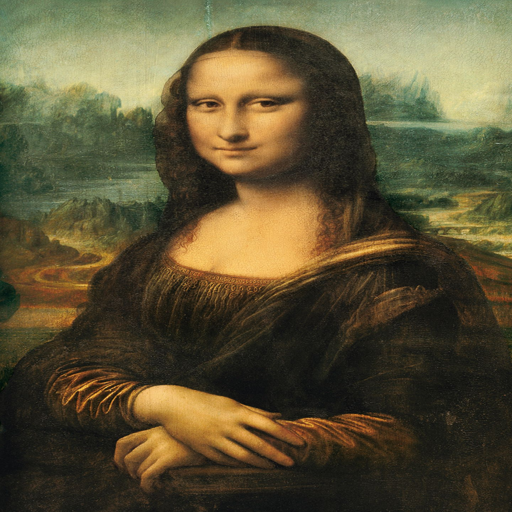

arafed painting of a woman with a long hair and a smile


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 222.05it/s]

a close up of a painting of a woman, da vinci code, flat matte painting, her face is coated in a whitish, uncompressed png, similar to the mona lisa, stable diffusion ai, smiling woman, simple drawing, unshaded


In [8]:
img_url = "https://github.com/pix2pixzero/pix2pix-zero/raw/main/assets/test_images/cats/cat_6.png"
img_url = "https://image.geo.de/30143964/t/cC/v3/w1440/r0/-/mona-lisa-p-1024727412-jpg--81961-.jpg"

rawimage = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((512, 512))
display(rawimage)

# generate caption
caption = blipcaptioner.generate_caption(rawimage)
print(caption)

caption = clipinterrogator.generate_caption(rawimage)
print(caption)

In [77]:
@dataclass
class InversionPipelineOutput(BaseOutput):
    """
    Output class for Stable Diffusion pipelines.

    Args:
        latents (`torch.FloatTensor`)
            inverted latents tensor
        images (`List[PIL.Image.Image]` or `np.ndarray`)
            List of denoised PIL images of length `batch_size` or numpy array of shape `(batch_size, height, width,
            num_channels)`. PIL images or numpy array present the denoised images of the diffusion pipeline.
    """

    latents: torch.FloatTensor
    images: Union[List[PIL.Image.Image], np.ndarray]


class StableDiffusionPipelinePartialInversion(StableDiffusionPix2PixZeroPipeline):
    @torch.no_grad()
    def denoise(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,   # 
        denoise_from: int = 0,      # which of the selected timesteps to start denoising from, by default from the very beginning
        denoise_steps: int = None,   # how many steps to run the denoising for, if None, the until the very end
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
    ):
        r"""
        The call function to the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide image generation. If not defined, you need to pass `prompt_embeds`.
            height (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                A higher guidance scale value encourages the model to generate images closely linked to the text
                `prompt` at the expense of lower image quality. Guidance scale is enabled when `guidance_scale > 1`.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide what to not include in image generation. If not defined, you need to
                pass `negative_prompt_embeds` instead. Ignored when not using guidance (`guidance_scale < 1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) from the [DDIM](https://arxiv.org/abs/2010.02502) paper. Only applies
                to the [`~schedulers.DDIMScheduler`], and is ignored in other schedulers.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor is generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs (prompt weighting). If not
                provided, text embeddings are generated from the `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs (prompt weighting). If
                not provided, `negative_prompt_embeds` are generated from the `negative_prompt` input argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that calls every `callback_steps` steps during inference. The function is called with the
                following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function is called. If not specified, the callback is called at
                every step.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the [`AttentionProcessor`] as defined in
                [`self.processor`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            guidance_rescale (`float`, *optional*, defaults to 0.7):
                Guidance rescale factor from [Common Diffusion Noise Schedules and Sample Steps are
                Flawed](https://arxiv.org/pdf/2305.08891.pdf). Guidance rescale factor should fix overexposure when
                using zero terminal SNR.

        Examples:

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] is returned,
                otherwise a `tuple` is returned where the first element is a list with the generated images and the
                second element is a list of `bool`s indicating whether the corresponding generated image contains
                "not-safe-for-work" (nsfw) content.
        """
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        print(prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds)
        StableDiffusionPipeline.check_inputs(self,
            prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
        )
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=text_encoder_lora_scale,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        # print(f"---- num_channels_latents: {num_channels_latents}")
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order

        print(f"Normal timesteps: {timesteps}")
        denoise_steps = denoise_steps if denoise_steps is not None else num_inference_steps - denoise_from
        timesteps = timesteps[denoise_from:denoise_from + denoise_steps]
        print(f"Selected timesteps: {timesteps}")
        
        with self.progress_bar(total=len(timesteps)) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                if do_classifier_free_guidance and guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = latents
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

    
    @torch.no_grad()
    def invert(
        self,
        prompt: Optional[str] = None,
        image: Union[
            torch.FloatTensor,
            PIL.Image.Image,
            np.ndarray,
            List[torch.FloatTensor],
            List[PIL.Image.Image],
            List[np.ndarray],
        ] = None,
        num_inference_steps: int = 50,
        # invert_from: int = 0,
        invert_steps: Tuple[int] = None,
        extra_invert_steps : int = None,
        guidance_scale: float = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        cross_attention_guidance_amount: float = 0.1,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        lambda_auto_corr: float = 20.0,
        lambda_kl: float = 20.0,
        num_reg_steps: int = 5,
        num_auto_corr_rolls: int = 5,
    ):
        r"""
        Function used to generate inverted latents given a prompt and image.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            image (`torch.FloatTensor` `np.ndarray`, `PIL.Image.Image`, `List[torch.FloatTensor]`, `List[PIL.Image.Image]`, or `List[np.ndarray]`):
                `Image`, or tensor representing an image batch which will be used for conditioning. Can also accept
                image latents as `image`, if passing latents directly, it will not be encoded again.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 1):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            cross_attention_guidance_amount (`float`, defaults to 0.1):
                Amount of guidance needed from the reference cross-attention maps.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            lambda_auto_corr (`float`, *optional*, defaults to 20.0):
                Lambda parameter to control auto correction
            lambda_kl (`float`, *optional*, defaults to 20.0):
                Lambda parameter to control Kullback–Leibler divergence output
            num_reg_steps (`int`, *optional*, defaults to 5):
                Number of regularization loss steps
            num_auto_corr_rolls (`int`, *optional*, defaults to 5):
                Number of auto correction roll steps

        Examples:

        Returns:
            [`~pipelines.stable_diffusion.pipeline_stable_diffusion_pix2pix_zero.Pix2PixInversionPipelineOutput`] or
            `tuple`:
            [`~pipelines.stable_diffusion.pipeline_stable_diffusion_pix2pix_zero.Pix2PixInversionPipelineOutput`] if
            `return_dict` is True, otherwise a `tuple. When returning a tuple, the first element is the inverted
            latents tensor and then second is the corresponding decoded image.
        """
        # 1. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]
        if cross_attention_kwargs is None:
            cross_attention_kwargs = {}

        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Preprocess image
        image = self.image_processor.preprocess(image)

        # 4. Prepare latent variables
        latents = self.prepare_image_latents(image, batch_size, self.vae.dtype, device, generator)

        # 5. Encode input prompt
        num_images_per_prompt = 1
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            prompt_embeds=prompt_embeds,
        )

        # 4. Prepare timesteps
        self.inverse_scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.inverse_scheduler.timesteps

        # 6. Rejig the UNet so that we can obtain the cross-attenion maps and
        # use them for guiding the subsequent image generation.

        # 7. Denoising loop where we obtain the cross-attention maps.
        return_single = False
        if invert_steps is None:
            invert_steps = (num_inference_steps,)
        elif isinstance(invert_steps, int):
            invert_steps = (invert_steps,)
            return_single = True
        num_warmup_steps = len(timesteps) - num_inference_steps * self.inverse_scheduler.order
        invert_from = 0
        print(f"Normal timesteps: {timesteps}")
        timesteps = timesteps[invert_from:invert_from + max(invert_steps)]
        print(f"Selected timesteps: {timesteps}")
        return_timesteps = [timesteps[i-1] for i in invert_steps]
        print(f"Return timesteps: {return_timesteps}")

        ret_latents = {}
        
        with self.progress_bar(total=len(timesteps)) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.inverse_scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # regularization of the noise prediction
                with torch.enable_grad():
                    for _ in range(num_reg_steps):
                        if lambda_auto_corr > 0:
                            for _ in range(num_auto_corr_rolls):
                                var = torch.autograd.Variable(noise_pred.detach().clone(), requires_grad=True)

                                # Derive epsilon from model output before regularizing to IID standard normal
                                var_epsilon = self.get_epsilon(var, latent_model_input.detach(), t)

                                l_ac = self.auto_corr_loss(var_epsilon, generator=generator)
                                l_ac.backward()

                                grad = var.grad.detach() / num_auto_corr_rolls
                                noise_pred = noise_pred - lambda_auto_corr * grad

                        if lambda_kl > 0:
                            var = torch.autograd.Variable(noise_pred.detach().clone(), requires_grad=True)

                            # Derive epsilon from model output before regularizing to IID standard normal
                            var_epsilon = self.get_epsilon(var, latent_model_input.detach(), t)

                            l_kld = self.kl_divergence(var_epsilon)
                            l_kld.backward()

                            grad = var.grad.detach()
                            noise_pred = noise_pred - lambda_kl * grad

                        noise_pred = noise_pred.detach()

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.inverse_scheduler.step(noise_pred, t, latents).prev_sample

                if t in return_timesteps:
                    ret_latents[t.cpu().item()] = latents

                # call the callback, if provided
                if i == len(timesteps) - 1 or (
                    (i + 1) > num_warmup_steps and (i + 1) % self.inverse_scheduler.order == 0
                ):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        rets = []
        # print(ret_latents.keys())
        for select_t in return_timesteps:
            latents = ret_latents[select_t.cpu().item()]
            inverted_latents = latents.detach().clone()

            # 8. Post-processing
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
            image = self.image_processor.postprocess(image, output_type=output_type)

            if not return_dict:
                rets.append((inverted_latents, image))
            else:
                rets.append(InversionPipelineOutput(latents=inverted_latents, images=image))
                
        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if len(rets) == 1 and return_single:
            return rets[0]
        else:
            return rets

    def compute_reconstruction(self, x0, prompt, reconstruction_steps, num_inference_steps=50):
        x_inv = self.invert(prompt, x0, invert_steps=reconstruction_steps, num_inference_steps=num_inference_steps).latents
        x_recon = self.denoise(prompt, latents=x_inv, denoise_from=num_inference_steps-reconstruction_steps, num_inference_steps=num_inference_steps).images
        return x_recon[0]

    def compute_reconstruction_distance(self, x0, prompt, reconstruction_steps, num_inference_steps=50, distance="l2"):
        xrecon = self.compute_reconstruction(x0, prompt, reconstruction_steps, num_inference_steps=50)
        if distance == "l2":
            x0_pt = pil_to_tensor(x0).float()/127.5-1
            xrecon_pt = pil_to_tensor(xrecon).float()/127.5-1
            # print(x0_pt.shape, xrecon_pt.shape)
            x0_pt = x0_pt.flatten()[None, None]
            xrecon_pt = xrecon_pt.flatten()[None, None]
            dist = torch.cdist(x0_pt, xrecon_pt, p=2)[0, 0]
        else:
            raise Exception("Unsupported distance")
        return dist

    def compute_latent_reconstruction_distance(self, x0, prompt, reconstruction_steps, extra_steps=1, num_inference_steps=50, distance="l2"):
        ret = self.invert(prompt, x0, invert_steps=(reconstruction_steps, reconstruction_steps+extra_steps), num_inference_steps=num_inference_steps)
        x_inv, x_inv_extra = ret
        x_extra_recon = self.denoise(prompt, latents=x_inv_extra.latents, denoise_from=num_inference_steps-reconstruction_steps, 
                                     denoise_steps=extra_steps,
                                     num_inference_steps=num_inference_steps, output_type="latent").images
        # print(x_inv.latents.shape, x_extra_recon.shape, x_inv.latents.min(), x_inv.latents.max(), x_inv.latents.mean())
        if distance == "l2":
            x_inv = x_inv.latents[0]
            x_extra_recon = x_extra_recon[0]
            x_inv = x_inv.flatten()[None, None]
            x_extra_recon = x_extra_recon.flatten()[None, None]
            dist = torch.cdist(x_inv, x_extra_recon, p=2)[0, 0]
        else:
            raise Exception("Unsupported distance")
        return dist
        



In [78]:
sd_model_ckpt = 'runwayml/stable-diffusion-v1-5'

pipeline = StableDiffusionPipelinePartialInversion.from_pretrained(sd_model_ckpt, safety_checker=None)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class '__main__.StableDiffusionPipelinePartialInversion'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


a photo of a banana taped to a wall with black duct tape 512 512 1 None None None
Normal timesteps: tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')
Selected timesteps: tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')


  0%|          | 0/50 [00:00<?, ?it/s]

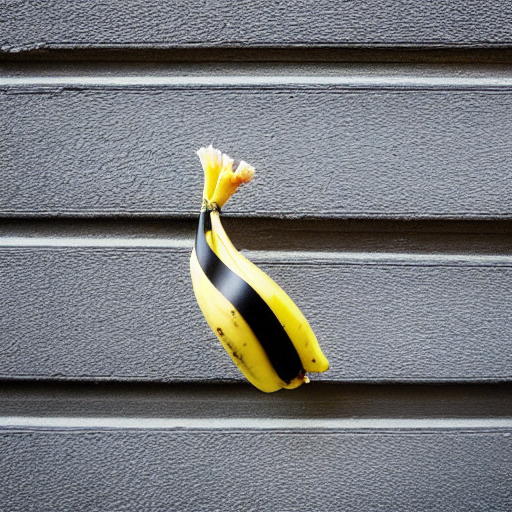

In [13]:
prompt = "a photo of a banana taped to a wall with black duct tape"
x0 = pipeline.denoise(prompt).images[0]
display(x0)

In [26]:
x_inv_10 = pipeline.invert(prompt, x0, invert_steps=5).latents[0]
print(x_inv_10.shape)

Normal timesteps: tensor([-19,   1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241,
        261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521,
        541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801,
        821, 841, 861, 881, 901, 921, 941, 961], device='cuda:0')
Selected timesteps: tensor([-19,   1,  21,  41,  61], device='cuda:0')
Return timesteps: [tensor(61, device='cuda:0')]


  0%|          | 0/5 [00:00<?, ?it/s]

dict_keys([61])
torch.Size([4, 64, 64])


a photo of a banana taped to a wall with black duct tape 512 512 1 None None None
Normal timesteps: tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')
Selected timesteps: tensor([81, 61, 41, 21,  1], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]

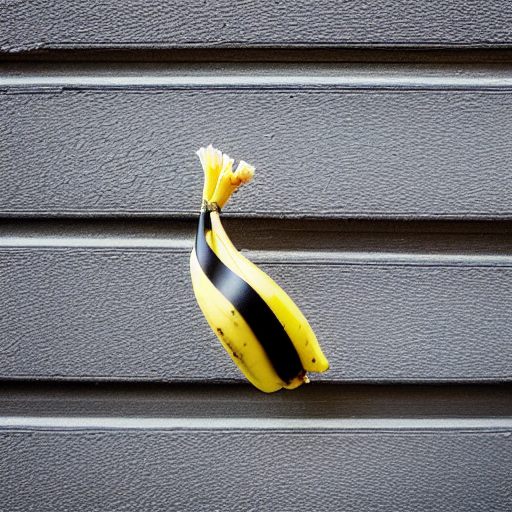

In [27]:
x_0_from10_recon = pipeline.denoise(prompt, latents=x_inv_10[None], denoise_from=45).images[0]
display(x_0_from10_recon)

In [34]:
def compute_diff(img1, img2):
    x_diff = PIL.ImageChops.subtract(img1, img2, offset=127, scale=1)
    return x_diff

Normal timesteps: tensor([-19,   1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241,
        261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521,
        541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801,
        821, 841, 861, 881, 901, 921, 941, 961], device='cuda:0')
Selected timesteps: tensor([-19,   1,  21,  41,  61], device='cuda:0')
Return timesteps: [tensor(61, device='cuda:0')]


  0%|          | 0/5 [00:00<?, ?it/s]

a photo of a banana taped to a wall with black duct tape 512 512 1 None None None
Normal timesteps: tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')
Selected timesteps: tensor([81, 61, 41, 21,  1], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]

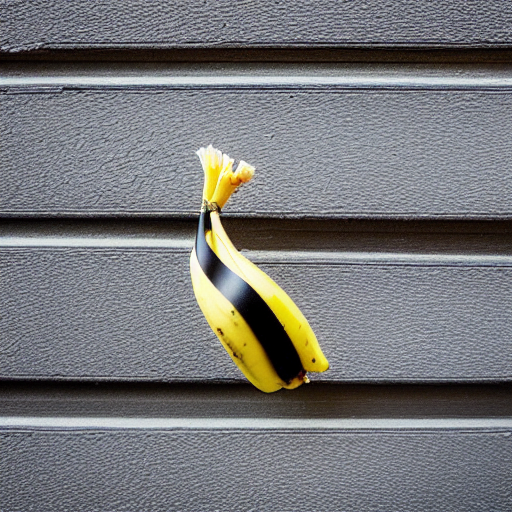

In [73]:
xrecon = pipeline.compute_reconstruction(x0, prompt, 5, num_inference_steps=50)
display(xrecon)
# xrecon2 = pipeline.compute_reconstruction(x0, prompt, 100, num_inference_steps=1000)

In [69]:
recondist = pipeline.compute_reconstruction_distance(x0, prompt, 5, num_inference_steps=50)
recondist

Normal timesteps: tensor([-19,   1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241,
        261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521,
        541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801,
        821, 841, 861, 881, 901, 921, 941, 961], device='cuda:0')
Selected timesteps: tensor([-19,   1,  21,  41,  61], device='cuda:0')
Return timesteps: [tensor(61, device='cuda:0')]


  0%|          | 0/5 [00:00<?, ?it/s]

a photo of a banana taped to a wall with black duct tape 512 512 1 None None None
Normal timesteps: tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')
Selected timesteps: tensor([81, 61, 41, 21,  1], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


tensor([106.9738])

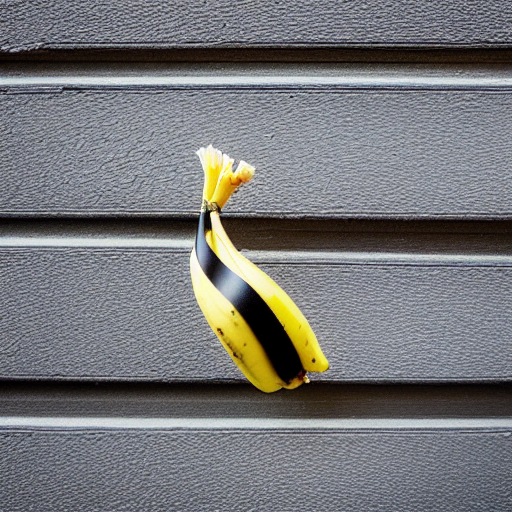

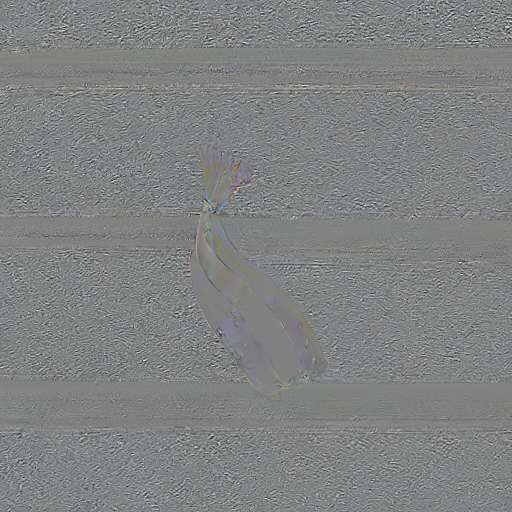

In [35]:
display(xrecon)
display(compute_diff(x0, xrecon))
# display(compute_diff(x0, xrecon2))

In [81]:
recondist = pipeline.compute_latent_reconstruction_distance(x0, prompt, 1, 5, num_inference_steps=50)
recondist

Normal timesteps: tensor([-19,   1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241,
        261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521,
        541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801,
        821, 841, 861, 881, 901, 921, 941, 961], device='cuda:0')
Selected timesteps: tensor([-19,   1,  21,  41,  61,  81], device='cuda:0')
Return timesteps: [tensor(-19, device='cuda:0'), tensor(81, device='cuda:0')]


  0%|          | 0/6 [00:00<?, ?it/s]

a photo of a banana taped to a wall with black duct tape 512 512 1 None None None
Normal timesteps: tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')
Selected timesteps: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([20.7144], device='cuda:0')